## Imports

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from functools import lru_cache
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

# !pip install onnx
# !pip install onnxruntime
import torch.onnx
import onnxruntime
import onnx

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data loading

In [2]:
@lru_cache
def collect_addresses(mode='lung'):
  ''' collect paths to images from given folders'''
  
  lung_folder = '/content/X-Ray_segmentation/Lung-xray/'
  covid_folder = '/content/X-Ray_segmentation/Covid-xray/'

  if mode == 'lung':
    folder = lung_folder
  elif mode == 'covid':
    folder = covid_folder
  else:
    return

  files_dict = {'Train': [], 'Test': [], 'Val': []}

  for eval_method in files_dict:
    link = folder + eval_method + '/'
    image_files = os.listdir(link + 'images/')

    for image_file in image_files:
      image = link + 'images/' + image_file
      mask = link + 'masks/' + image_file
      files_dict[eval_method].append((image, mask))
  
  return files_dict

In [3]:
class XRayDataset(Dataset):
  ''' Dataset of X-ray images
      Attributes:
        data_dict: dictionary of sets
        mode: training mode '''

  def __init__(self, data_dict, mode='Train'):
    self.data_addresses = data_dict[mode]
  
  def to_standart_format(self, image, mask):
    ''' transform to standart image format'''
    
    if image.shape[1] > 256:
      resize = torchvision.transforms.Resize(256)
      image, mask = resize(image), resize(mask)

    elif image.shape[1] < 256:
      pad = torchvision.transforms.Pad(256-image.shape[1])
      image, mask = pad(image), pad(mask)
    
    image = image/255
    mask = mask/255

    if image.shape[0] == 1:
      image = torch.cat([image, image, image])
    
    return (image, mask)

  def __len__(self):
    return len(self.data_addresses)
  
  def __getitem__(self, idx):
    image, mask = self.data_addresses[idx]
    image, mask = read_image(image), read_image(mask)
    image, mask = self.to_standart_format(image, mask)

    return (image, mask)

In [4]:
lung_addresses = collect_addresses('lung')
covid_addresses = collect_addresses('covid')

lung_seg_trainset = XRayDataset(lung_addresses, 'Train')
lung_seg_testset = XRayDataset(lung_addresses, 'Test')
lung_seg_valset = XRayDataset(lung_addresses, 'Val')

covid_seg_trainset = XRayDataset(covid_addresses, 'Train')
covid_seg_testset = XRayDataset(covid_addresses, 'Test')
covid_seg_valset = XRayDataset(covid_addresses, 'Val')

lung_seg_trainloader = DataLoader(lung_seg_trainset, batch_size=16, shuffle=True)
lung_seg_testloader = DataLoader(lung_seg_testset, batch_size=16, shuffle=True)
lung_seg_valloader = DataLoader(lung_seg_valset, batch_size=16, shuffle=True)

covid_seg_trainloader = DataLoader(covid_seg_trainset, batch_size=16, shuffle=True)
covid_seg_testloader = DataLoader(covid_seg_testset, batch_size=16, shuffle=True)
covid_seg_valloader = DataLoader(covid_seg_valset, batch_size=16, shuffle=True)

In [5]:
pretrain_loaders = {'train': lung_seg_trainloader, 'test': lung_seg_testloader,
                    'val': lung_seg_valloader}

train_loaders = {'train': covid_seg_trainloader, 'test': covid_seg_testloader,
                 'val': covid_seg_valloader}

## Model training

In [6]:
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5).to(device)
model.outc = nn.Sequential(nn.Conv2d(64, 1, (1,1)), nn.Sigmoid()).to(device)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth


  0%|          | 0.00/118M [00:00<?, ?B/s]

In [7]:
class evaluation:
  ''' Evaluating a model
      Attributes:
        model: model instance
        loaders: dictionary of loaders '''

  def __init__(self, model, loaders=None):
    self.model = model
    
    if loaders:
      self.trainloader = loaders['train']
      self.testloader = loaders['test']
      self.valloader = loaders['val']
  
  def run(self, mode='train', epochs=1):
    self.loss_fn =  self.DiceLoss
    self.optimizer = torch.optim.Adam(self.model.parameters())

    if mode == 'train': self.train(epochs)
    elif mode == 'test': self.test()
    elif mode == 'val': self.val()
  
  def custom_run(self, image_path):
    self.model.eval()
    img = read_image(image_path)
    input_size = 256
    
    if img.shape[1] > input_size:
      img = torchvision.transforms.Resize(input_size)(img)
    elif img.shape[1] < input_size:
      img = torchvision.transforms.Pad(input_size-img.shape[1])(img)
    
    if img.shape[0] == 1:
      img = torch.cat([img, img, img])
    
    with torch.no_grad():
      squeezed_img = (img/255).unsqueeze(0).to(device, dtype=torch.float32)
      mask = self.model(squeezed_img).cpu()[0]
      masked_image = torchvision.utils.draw_segmentation_masks(img, (mask > 0.9), colors=['red'])

    plt.imshow(masked_image.permute(1, 2, 0))
  
  def DiceLoss(self, pred_mask, true_mask):
    ''' Implementation of DiceLoss'''

    inter = (pred_mask * true_mask).sum(dim=[1,2,3])
    union = pred_mask.sum(dim=[1,2,3]) + true_mask.sum(dim=[1,2,3])
    dice = 1-(2*inter + 1)/(union + 1)

    return dice.mean()
  
  def calc_metrics(self, pred_mask, true_mask):
    ''' Calculating IoU, PA metrics '''
    
    inter = (pred_mask * true_mask).sum(dim=[1,2,3])
    union = pred_mask.sum(dim=[1,2,3]) + true_mask.sum(dim=[1,2,3])
    
    IoU = (inter + 1)/(union + 1)
    PA = (inter + 1)/(true_mask.sum(dim=[1,2,3]) + 1)

    return IoU.mean(), PA.mean()

  def train(self, epochs):
    self.model.train()
    for epoch in range(epochs):
      for batch, (image, mask) in enumerate(self.trainloader):
        image = image.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        pred = self.model(image)
        loss = self.loss_fn(pred, mask)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

      IoU, PA =  self.calc_metrics(pred, mask)

      print("Epoch: {}, DiceLoss: {:.2f}, IoU: {:.2f}, \
      PA: {:.2f}".format(epoch, loss.item(), IoU, PA))

    print('Training finished successfully!')
  
  def test(self):
    self.model.eval()
    metrics = []

    with torch.no_grad():
      for batch, (image, mask) in enumerate(self.testloader):
        image = image.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        pred = self.model(image)
        loss = self.loss_fn(pred, mask)

        IoU, PA = self.calc_metrics(pred, mask)
        metrics.append((loss.item(), IoU, PA))
        
    metrics = torch.tensor(metrics)
    avg_metrics = torch.sum(metrics, 0)/len(metrics)

    print("DiceLoss: {:.2f}, IoU: {:.2f}, \
    PA: {:.2f}".format(*avg_metrics))

    print('Testing finished successfully!')
  
  def val(self):
    self.model.eval()
    metrics = []
    
    with torch.no_grad():
      for batch, (image, mask) in enumerate(self.valloader):
        image = image.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        pred = self.model(image)
        loss = self.loss_fn(pred, mask)

        IoU, PA = self.calc_metrics(pred, mask)
        metrics.append((loss.item(), IoU, PA))
        
    metrics = torch.tensor(metrics)
    avg_metrics = torch.sum(metrics, 0)/len(metrics)

    print("DiceLoss: {:.2f}, IoU: {:.2f}, \
    PA: {:.2f}".format(*avg_metrics))

    print('Validation finished successfully!')
  
  def save(self, path):
    torch.save(self.model, path)
    print('Model saved successfully!')

## Evaluation

In [ ]:
lung_eval = evaluation(model, pretrain_loaders)
lung_eval.run('train')
lung_eval.run('val')
lung_eval.run('test')
lung_eval.custom_run('/content/x-ray-image-2b_full.jpg')

In [ ]:
lung_eval.save('/content/lung_seg_model.pt')

Model saved successfully!


Epoch: 0, DiceLoss: 0.70, IoU: 0.15,       PA: 0.87
Epoch: 1, DiceLoss: 0.64, IoU: 0.18,       PA: 0.95
Epoch: 2, DiceLoss: 0.65, IoU: 0.17,       PA: 0.86
Epoch: 3, DiceLoss: 0.60, IoU: 0.20,       PA: 0.90
Training finished successfully!
DiceLoss: 0.66, IoU: 0.17,     PA: 0.92
Validation finished successfully!
DiceLoss: 0.66, IoU: 0.17,     PA: 0.92
Testing finished successfully!


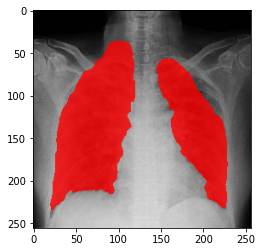

In [ ]:
covid_eval = evaluation(model, train_loaders)
covid_eval.run('train', 4)
covid_eval.run('val')
covid_eval.run('test')
covid_eval.custom_run('/content/x-ray-image-2b_full.jpg')

In [ ]:
covid_eval.save('/content/covid_seg_model.pt')

Model saved successfully!


## ONNX

In [8]:
class ONNX:
  def __init__(self, model_path, dummy_input, onnx_path):
    self.model_path = model_path
    self.dummy_input = dummy_input
    self.onnx_path = onnx_path
  
  def to_onnx(self):
    model = torch.load(self.model_path)
    model.eval()

    torch.onnx.export(model, self.dummy_input, self.onnx_path, export_params=True)
  
  def check_onnx(self):
    onnx_model = onnx.load(self.onnx_path)
    onnx.checker.check_model(onnx_model)

In [17]:
dummy_input = torch.zeros((1, 3, 256, 256)).to(device)
lung_onnx = ONNX('/content/lung_seg_model.pt', dummy_input, '/content/lung_seg_onnx.onnx')
covid_onnx = ONNX('/content/covid_seg_model.pt', dummy_input, '/content/covid_seg_onnx.onnx')

In [18]:
lung_onnx.to_onnx()
covid_onnx.to_onnx()

/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:1178: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/o

In [19]:
lung_onnx.check_onnx()
covid_onnx.check_onnx()